## Case Study: Chapter 4 - Time Series and Snapshots for Renewable Integration 

Authors:   Neeraj Dhanraj Bokde  (www.neerajbokde.in)
           and Carlo Fanara 
           
Affiliation: Renewable & Sustainable Energy Research Center, TII, Abu Dhabi

Corresponding author: neeraj.bokde@tii.ae/neerajdhanraj@gmail.com

Description:
   This script models a two-bus power system using PyPSA, illustrating how to
   represent time-varying renewable generation (solar, wind) and flexible gas
   backup using hourly snapshots and time series.
   Dispatch is solved using Linear Optimal Power Flow (LOPF), and results
   are visualized for teaching and benchmarking purposes.

 Book Reference:
   Bokde, N. D., & Fanara, C. (2025). Advanced Modeling Techniques in PyPSA.
   In: The PyPSA Handbook: Integrated Power System Analysis and Renewable 
   Energy Modeling, Chapter 4.
   Publisher	Elsevier Science
   ISBN	044326631X, 9780443266317

 Software Dependencies:
   - Python 3.8+
   - pypsa (v0.21+ recommended)
   - numpy, pandas, matplotlib

 License: MIT

 Version: 1.0
 
 Date: June 2025
 

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


#### Step 1: Network Setup

Create the PyPSA network

In [2]:
network = pypsa.Network()

Add buses

In [3]:
network.add("Bus", "Bus 1", carrier="AC")
network.add("Bus", "Bus 2", carrier="AC")

Add transmission line

In [4]:
network.add("Line", "Line 1",
            bus0="Bus 1", bus1="Bus 2",
            x=0.1, r=0.01, s_nom=200, carrier="AC")

Add static load to Bus 2

In [5]:
network.add("Load", "Load 1", bus="Bus 2", p_set=50)

Add generators to Bus 1 (gas, solar, wind)

In [6]:
network.add("Generator", "Natural Gas Plant",
            bus="Bus 1", p_nom=40,
            carrier="gas", marginal_cost=50)
network.add("Generator", "Solar Plant",
            bus="Bus 1", p_nom=200,
            carrier="solar", marginal_cost=0)
network.add("Generator", "Wind Farm",
            bus="Bus 1", p_nom=120,
            carrier="wind", marginal_cost=0)

#### Step 2: Define Hourly Snapshots (Time Resolution)

Simulate 24 hours at hourly intervals

In [7]:
hours = pd.date_range('2024-01-01 00:00', '2024-01-01 23:00', freq='h')
network.set_snapshots(hours)

#### Step 3: Assign Time Series (Availability)

Synthetic solar profile: sinusoidal, peaks at midday

In [8]:
angle_range = np.linspace(-np.pi/2, 3*np.pi/2, len(hours))
solar_output = np.maximum(0, np.sin(angle_range))  # [0, 1]

Synthetic wind profile: random, 0.2-1.0 p.u.

In [9]:
np.random.seed(0)  # Reproducibility
wind_output = np.random.normal(0.5, 0.2, len(hours))
wind_output = np.clip(wind_output, 0.2, 1.0)

Assign per-unit availabilities (p_max_pu) for each generator

In [10]:
network.generators_t.p_max_pu = pd.DataFrame({
    'Solar Plant': solar_output,
    'Wind Farm': wind_output
}, index=hours)

#### Step 4: Solve LOPF (Linear Optimal Power Flow)

In [11]:
network.optimize(network.snapshots, solver_name='glpk')

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.54s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96 primals, 240 duals
Objective: 2.89e+03
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-kwao_035.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-0ngyrw6r.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-kwao_035.lp'...
240 rows, 96 columns, 312 non-zeros
1412 lines were read
GLPK Simplex Optimizer 5.0
240 rows, 96 columns, 312 non-zeros
Preprocessing...
12 rows, 24 columns, 24 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 12
      0: obj =   3.288824637e+04 inf =   1.200e+02 (12)
     12: obj =   2.688824637e+04 inf =   0.000e+00 (0)
*    26: obj =   2.888246367e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (164612 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solv

('ok', 'optimal')

#### Step 5: Extract and Print Dispatch Results

In [12]:
results = network.generators_t.p
print("Generator Dispatch (MW):")
print(results)

Generator Dispatch (MW):
Generator            Natural Gas Plant  Solar Plant  Wind Farm
snapshot                                                      
2024-01-01 00:00:00            0.00000       0.0000    50.0000
2024-01-01 01:00:00            0.00000       0.0000    50.0000
2024-01-01 02:00:00            0.00000       0.0000    50.0000
2024-01-01 03:00:00            0.00000       0.0000    50.0000
2024-01-01 04:00:00            0.00000       0.0000    50.0000
2024-01-01 05:00:00           13.45470       0.0000    36.5453
2024-01-01 06:00:00            0.00000      13.6485    36.3515
2024-01-01 07:00:00            0.00000      50.0000     0.0000
2024-01-01 08:00:00            0.00000      50.0000     0.0000
2024-01-01 09:00:00            0.00000      50.0000     0.0000
2024-01-01 10:00:00            0.00000      50.0000     0.0000
2024-01-01 11:00:00            0.00000      50.0000     0.0000
2024-01-01 12:00:00            0.00000      50.0000     0.0000
2024-01-01 13:00:00           

#### Step 6: Plot Results for Analysis

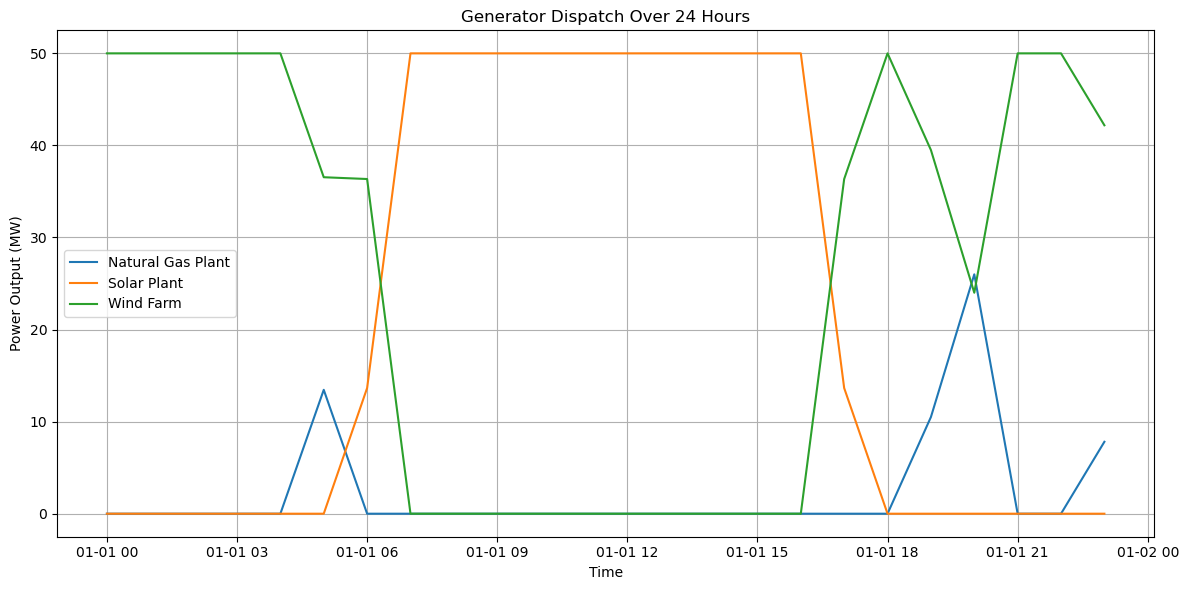

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(results.index, results["Natural Gas Plant"], label='Natural Gas Plant')
plt.plot(results.index, results["Solar Plant"], label='Solar Plant')
plt.plot(results.index, results["Wind Farm"], label='Wind Farm')
plt.xlabel('Time')
plt.ylabel('Power Output (MW)')
plt.title('Generator Dispatch Over 24 Hours')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### End of Case Study: Chapter 4